# Predict Bike Sharing Demand with AutoGluon

### Install packages

In [ ]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

### Setup Kaggle API Key

In [3]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
!ls -la /root/

total 52
drwx------ 11 root nogroup 6144 May 12 00:39 .
drwxr-xr-x  1 root root      39 May 12 00:13 ..
drwxr-xr-x  3 root root    6144 May  4 22:17 .aws
-rw-------  1 root root     178 May 12 00:09 .bash_history
drwxr-xr-x  4 root root    6144 May 12 00:17 .cache
drwx------  3 root root    6144 May  4 22:20 .config
drwxr-xr-x  3 root root    6144 May  4 22:27 .ipython
drwxr-xr-x  3 root root    6144 May  4 22:27 .jupyter
drwxr-xr-x  2 root root    6144 May 12 00:39 .kaggle
drwxr-xr-x  3 root root    6144 May  4 22:17 .local
-rw-r--r--  1 root root       2 May 12 00:08 .sagemaker-jumpstart-tasks-status.json
-rw-r--r--  1 root root     211 May  4 22:33 .yarnrc
drwxr-xr-x  6 root root    6144 May 12 00:44 nd009t-c1-intro-to-ml-project-starter
drwxr-xr-x  9 root root    6144 May  4 22:21 nd009t-c1-intro-to-ml-templates


In [ ]:
!pip install python-dotenv

In [8]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
from dotenv import load_dotenv
import os

load_dotenv()

kaggle_key = os.getenv("KAGGLE_KEY")

kaggle_username = "sushmitha047"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

In [9]:
!ls -la /root/.kaggle

total 12
drwxr-xr-x  2 root root    6144 May 12 00:39 .
drwx------ 11 root nogroup 6144 May 12 00:39 ..
-rw-------  1 root root      71 May 12 00:47 kaggle.json


In [10]:
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 944.7 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.12-py3-none-any.whl size=102985 sha256=cc0a7cde78789239a61c83df0cba0d35fa988811a367ad3b7a9928dc06437b4b
  Stored in directory: /root/.cache/pip/wheels/1e/0b/7c/50f8e89c3d2f82838dbd7afeddffbb9357003009ada98216c7
Successfully built kaggle


In [11]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

  0%|                                                | 0.00/189k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 189k/189k [00:00<00:00, 5.15MB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [33]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("./data/train.csv", parse_dates=['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [34]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454


In [35]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("./test.csv", parse_dates=['datetime'])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [36]:
# Same thing as train and test dataset
submission = pd.read_csv("./Submission-1-HSSushmitha.csv")
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

In [37]:
train = train.drop(['casual', 'registered'], axis=1)

In [38]:
predictor = TabularPredictor(label='count', eval_metric='root_mean_squared_error')
predictor.fit(train_data=train, presets='best_quality', time_limit=600)

No path specified. Models will be saved in: "AutogluonModels/ag-20240512_011336"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240512_011336/ds_sub_fit/sub_fit_ho.
2024-05-12 01:13:36,381	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.

### Review AutoGluon's training run with ranking of models that did the best.

In [39]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -53.100012  root_mean_squared_error      20.070079  367.967745                0.000868           0.033912            3       True         12
1   RandomForestMSE_BAG_L2  -53.418914  root_mean_squared_error      15.483320  280.456834                0.617560          33.858850            2       True         11
2          LightGBM_BAG_L2  -55.031036  root_mean_squared_error      15.120436  276.266237                0.254676          29.668252            2       True         10
3        LightGBMXT_BAG_L2  -60.373522  root_mean_squared_error      19.196974  304.406731                4.331215          57.808747            2       True          9
4    KNeighborsDist_BAG_L1  -84.125061  root_mean_squared_error       0.157527    0.088399   

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -131.054161598899,
  'RandomForestMSE_BAG_L1': -116.54835939455667,
  'CatBoost_BAG_L1': -130.8597269870384,
  'ExtraTreesMSE_BAG_L1': -124.60067564699747,
  'WeightedEnsemble_

### Create predictions from test dataset

In [40]:
predictions = predictor.predict(test)
predictions.head()

0    23.313810
1    42.426521
2    45.667053
3    48.959900
4    51.603806
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [41]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.471313
std        89.912918
min         3.096898
25%        19.738113
50%        63.583305
75%       167.953400
max       367.364746
Name: count, dtype: float64

In [42]:
# How many negative values do we have?
negative_count = (predictions < 0).sum()
print(f"Number of negative predictions: {negative_count}")

Number of negative predictions: 0


In [43]:
# Set them to zero
predictions[predictions < 0] = 0

### Set predictions to submission dataframe, save, and submit

In [44]:
submission['count'] = predictions
submission.to_csv("Submission-1-HSSushmitha.csv", index=False)

In [45]:
!kaggle competitions submit -c bike-sharing-demand -f Submission-1-HSSushmitha.csv -m "first submission"

100%|█████████████████████████████████████████| 188k/188k [00:01<00:00, 149kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [46]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                      date                 description       status    publicScore  privateScore  
----------------------------  -------------------  ----------------  --------  -----------  ------------  
Submission-1-HSSushmitha.csv  2024-05-12 01:27:17  first submission  complete  1.80462      1.80462       


#### Initial score of 1.80462

## Step 4: Exploratory Data Analysis and Creating an additional feature

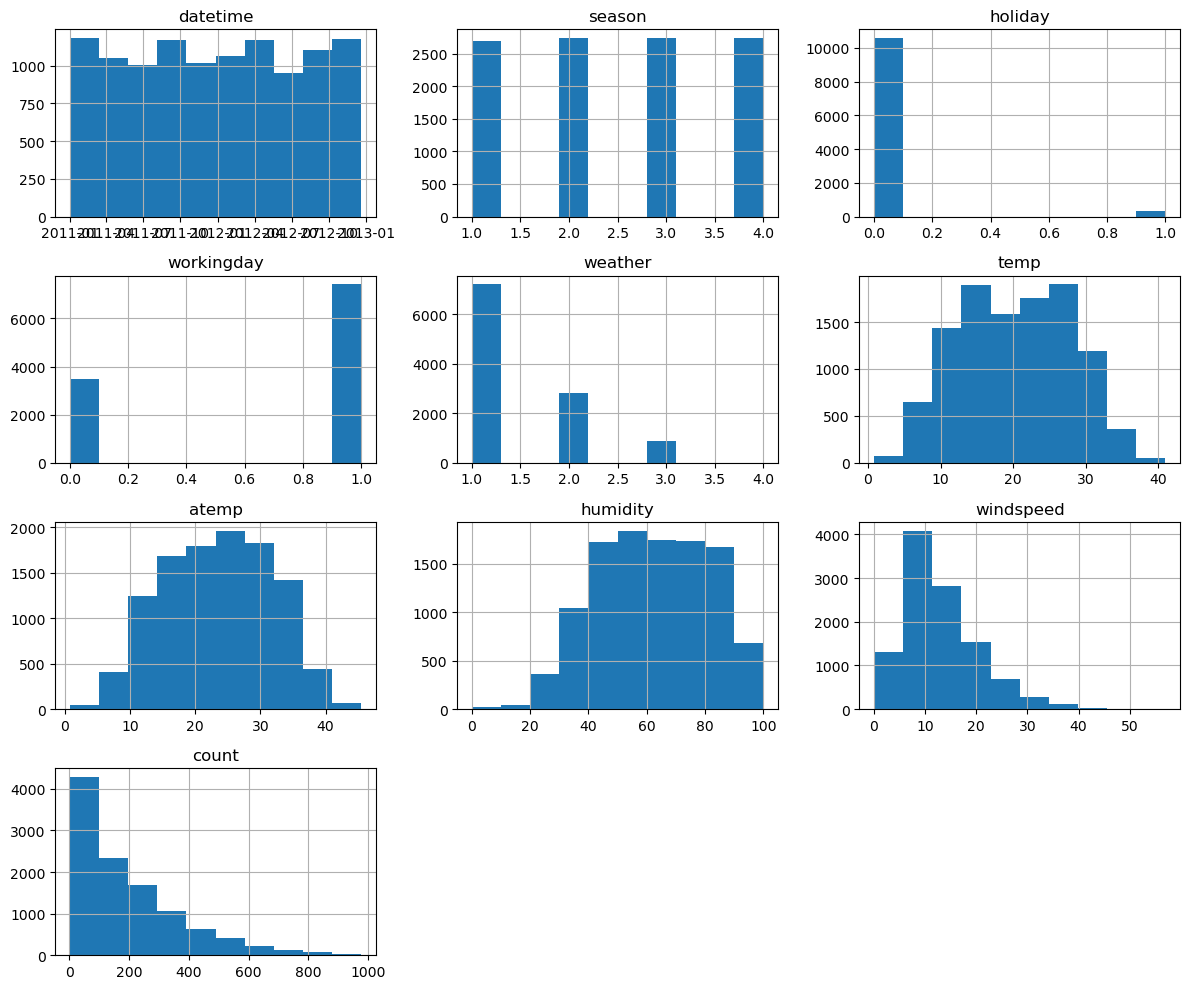

In [47]:
import matplotlib.pyplot as plt

# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

In [48]:
# create a new feature
train['hour'] = train['datetime'].dt.hour
train['day'] = train['datetime'].dt.day
train['month'] = train['datetime'].dt.month

test['hour'] = test['datetime'].dt.hour
test['day'] = test['datetime'].dt.day
test['month'] = test['datetime'].dt.month

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [49]:
train['season'] = train['season'].astype('category')
train['weather'] = train['weather'].astype('category')
test['season'] = test['season'].astype('category')
test['weather'] = test['weather'].astype('category')

In [50]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,0,1,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2,1,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,3,1,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,4,1,1


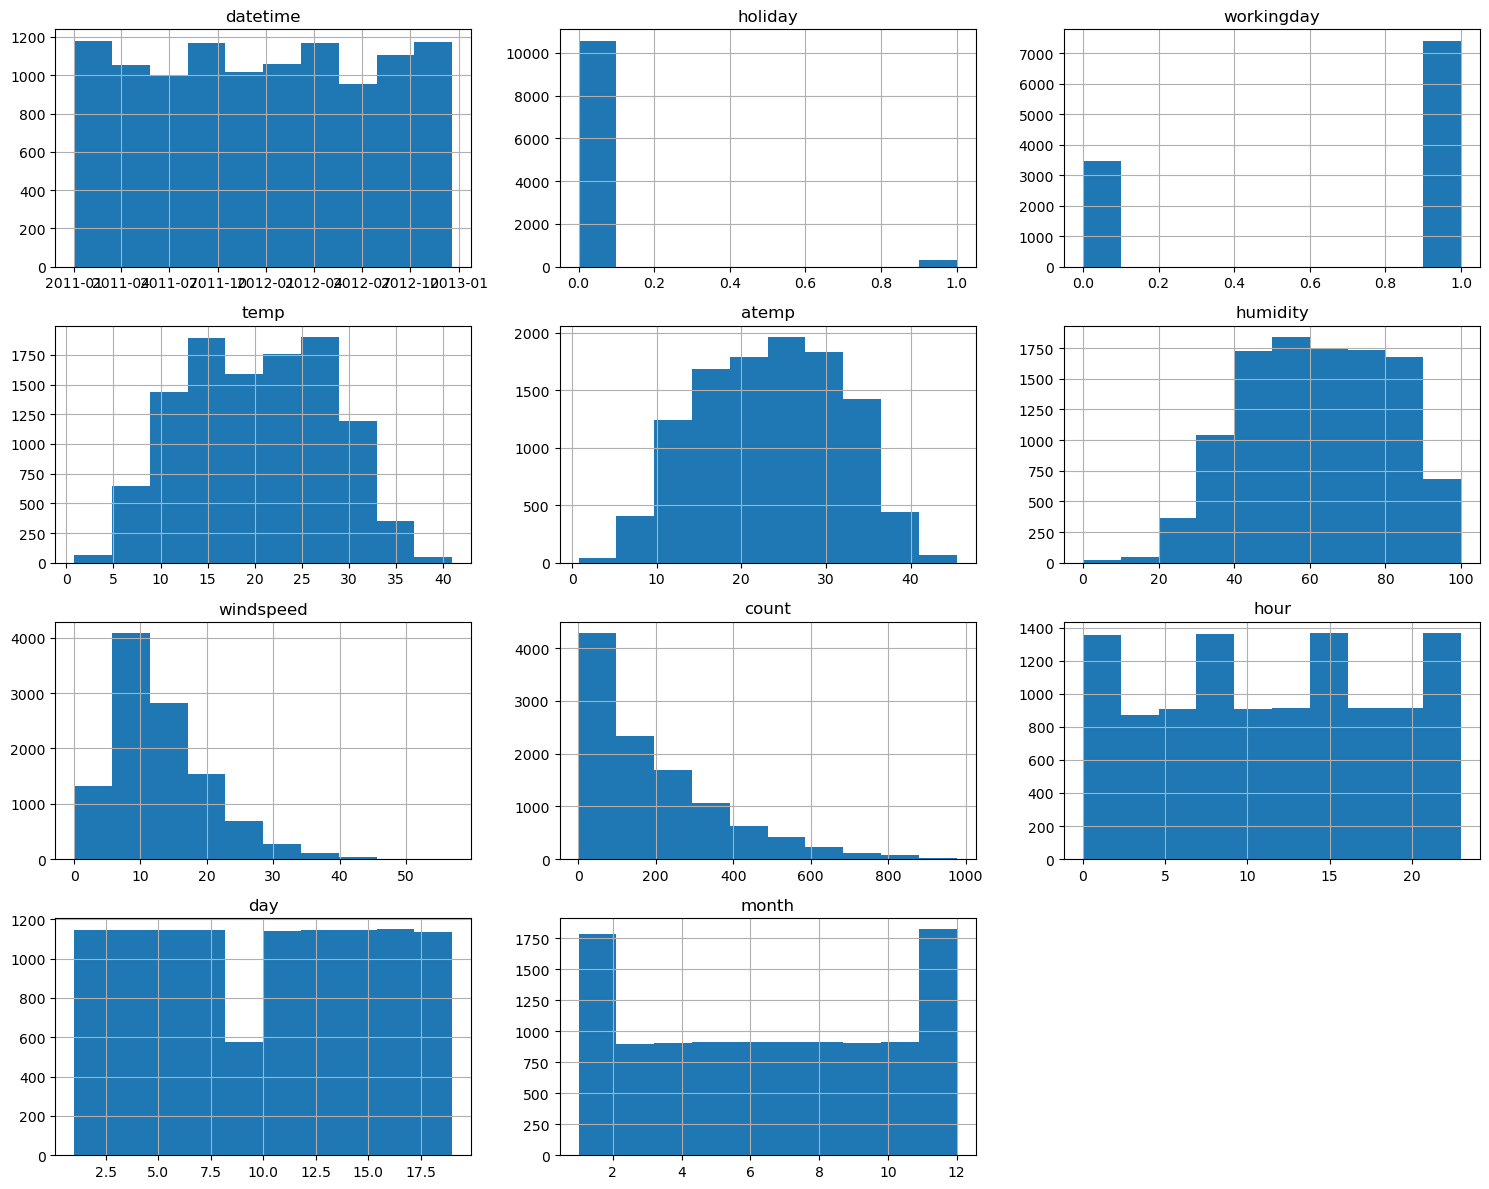

In [51]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(15, 12))
plt.tight_layout()
plt.show()

## Step 5: Rerun the model with the same settings as before, just with more features

In [52]:
predictor_new_features = TabularPredictor(label='count', eval_metric='root_mean_squared_error')
predictor_new_features.fit(train_data=train, presets='best_quality', time_limit=600)

No path specified. Models will be saved in: "AutogluonModels/ag-20240512_014820"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240512_014820/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 181 seconds

In [53]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.233831  root_mean_squared_error      26.035558  386.433689                0.000645           0.041973            3       True         12
1          LightGBM_BAG_L2  -30.494878  root_mean_squared_error      22.925574  298.479240                0.568189          33.623078            2       True         10
2        LightGBMXT_BAG_L2  -30.957252  root_mean_squared_error      24.774544  309.901665                2.417159          45.045503            2       True          9
3   RandomForestMSE_BAG_L2  -31.740740  root_mean_squared_error      23.049564  307.723134                0.692180          42.866972            2       True         11
4      WeightedEnsemble_L2  -32.379750  root_mean_squared_error      21.365514  255.317365   

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -34.51903091052072,
  'LightGBM_BAG_L1': -33.916920183145294,
  'RandomForestMSE_BAG_L1': -38.40890681984868,
  'CatBoost_BAG_L1': -35.62903968626214,
  'ExtraTreesMSE_BAG_L1': -38.50998417702855,
  'WeightedEnsemble_L

In [54]:
predictions_new_features = predictor_new_features.predict(test)
predictions_new_features.head()

0    15.644226
1     9.919064
2     9.102462
3     7.665875
4     6.626517
Name: count, dtype: float32

In [55]:
predictions_new_features.describe()

count    6493.000000
mean      162.075439
std       143.585892
min         1.553250
25%        50.077068
50%       124.434349
75%       232.309952
max       810.508240
Name: count, dtype: float64

In [56]:
# How many negative values do we have?
negative_count_predictions_new_features = (predictions_new_features < 0).sum()
print(f"Number of negative predictions with new features: {negative_count_predictions_new_features}")

Number of negative predictions with new features: 0


In [57]:
# Remember to set all negative values to zero
predictions_new_features[predictions_new_features < 0] = 0

In [58]:
submission_new_features = pd.read_csv("./Submission-2-HSSushmitha-new_features.csv")
submission_new_features.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [59]:
# Same submitting predictions
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("Submission-2-HSSushmitha-new_features.csv", index=False)

In [60]:
!kaggle competitions submit -c bike-sharing-demand -f Submission-2-HSSushmitha-new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 618kB/s]
Successfully submitted to Bike Sharing Demand

In [61]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                                   date                 description       status    publicScore  privateScore  
-----------------------------------------  -------------------  ----------------  --------  -----------  ------------  
Submission-2-HSSushmitha-new_features.csv  2024-05-12 02:00:40  new features      complete  0.62779      0.62779       
Submission-1-HSSushmitha.csv               2024-05-12 01:27:17  first submission  complete  1.80462      1.80462       


#### New Score of 0.62779

### Trying out with more features - My own trial - Overall - TRIAL 2

In [62]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,0,1,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2,1,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,3,1,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,4,1,1


In [63]:
# Weekday (0 = Monday, 6 = Sunday)
train['dayofweek'] = train['datetime'].dt.dayofweek
test['dayofweek'] = test['datetime'].dt.dayofweek

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,0,1,1,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2,1,1,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,3,1,1,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,4,1,1,5


In [64]:
# Is Weekend (1 for Saturday and Sunday, 0 otherwise)
train['is_weekend'] = train['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
test['is_weekend'] = test['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month,dayofweek,is_weekend
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,0,1,1,5,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1,1,1,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2,1,1,5,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,3,1,1,5,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,4,1,1,5,1


In [65]:
# Time of Day
def assign_part_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

train['part_of_day'] = train['hour'].apply(assign_part_of_day)
test['part_of_day'] = test['hour'].apply(assign_part_of_day)

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month,dayofweek,is_weekend,part_of_day
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,0,1,1,5,1,Night
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1,1,1,5,1,Night
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2,1,1,5,1,Night
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,3,1,1,5,1,Night
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,4,1,1,5,1,Night


In [66]:
# Convert to categorical
train['part_of_day'] = train['part_of_day'].astype('category')
test['part_of_day'] = test['part_of_day'].astype('category')

In [67]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month,dayofweek,is_weekend,part_of_day
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,0,1,1,5,1,Night
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1,1,1,5,1,Night
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2,1,1,5,1,Night
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,3,1,1,5,1,Night
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,4,1,1,5,1,Night


In [68]:
train['feels_like'] = 0.5 * (train['temp'] + train['atemp']) - 0.25 * train['windspeed'] + 0.5 * train['humidity']
test['feels_like'] = 0.5 * (test['temp'] + test['atemp']) - 0.25 * test['windspeed'] + 0.5 * test['humidity']

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month,dayofweek,is_weekend,part_of_day,feels_like
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,0,1,1,5,1,Night,52.6175
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1,1,1,5,1,Night,51.3275
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2,1,1,5,1,Night,51.3275
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,3,1,1,5,1,Night,49.6175
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,4,1,1,5,1,Night,49.6175


In [69]:
train['temp_time_of_day'] = train['temp'] * train['hour']
test['temp_time_of_day'] = test['temp'] * test['hour']

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month,dayofweek,is_weekend,part_of_day,feels_like,temp_time_of_day
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,0,1,1,5,1,Night,52.6175,0.00
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1,1,1,5,1,Night,51.3275,9.02
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2,1,1,5,1,Night,51.3275,18.04
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,3,1,1,5,1,Night,49.6175,29.52
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,4,1,1,5,1,Night,49.6175,39.36


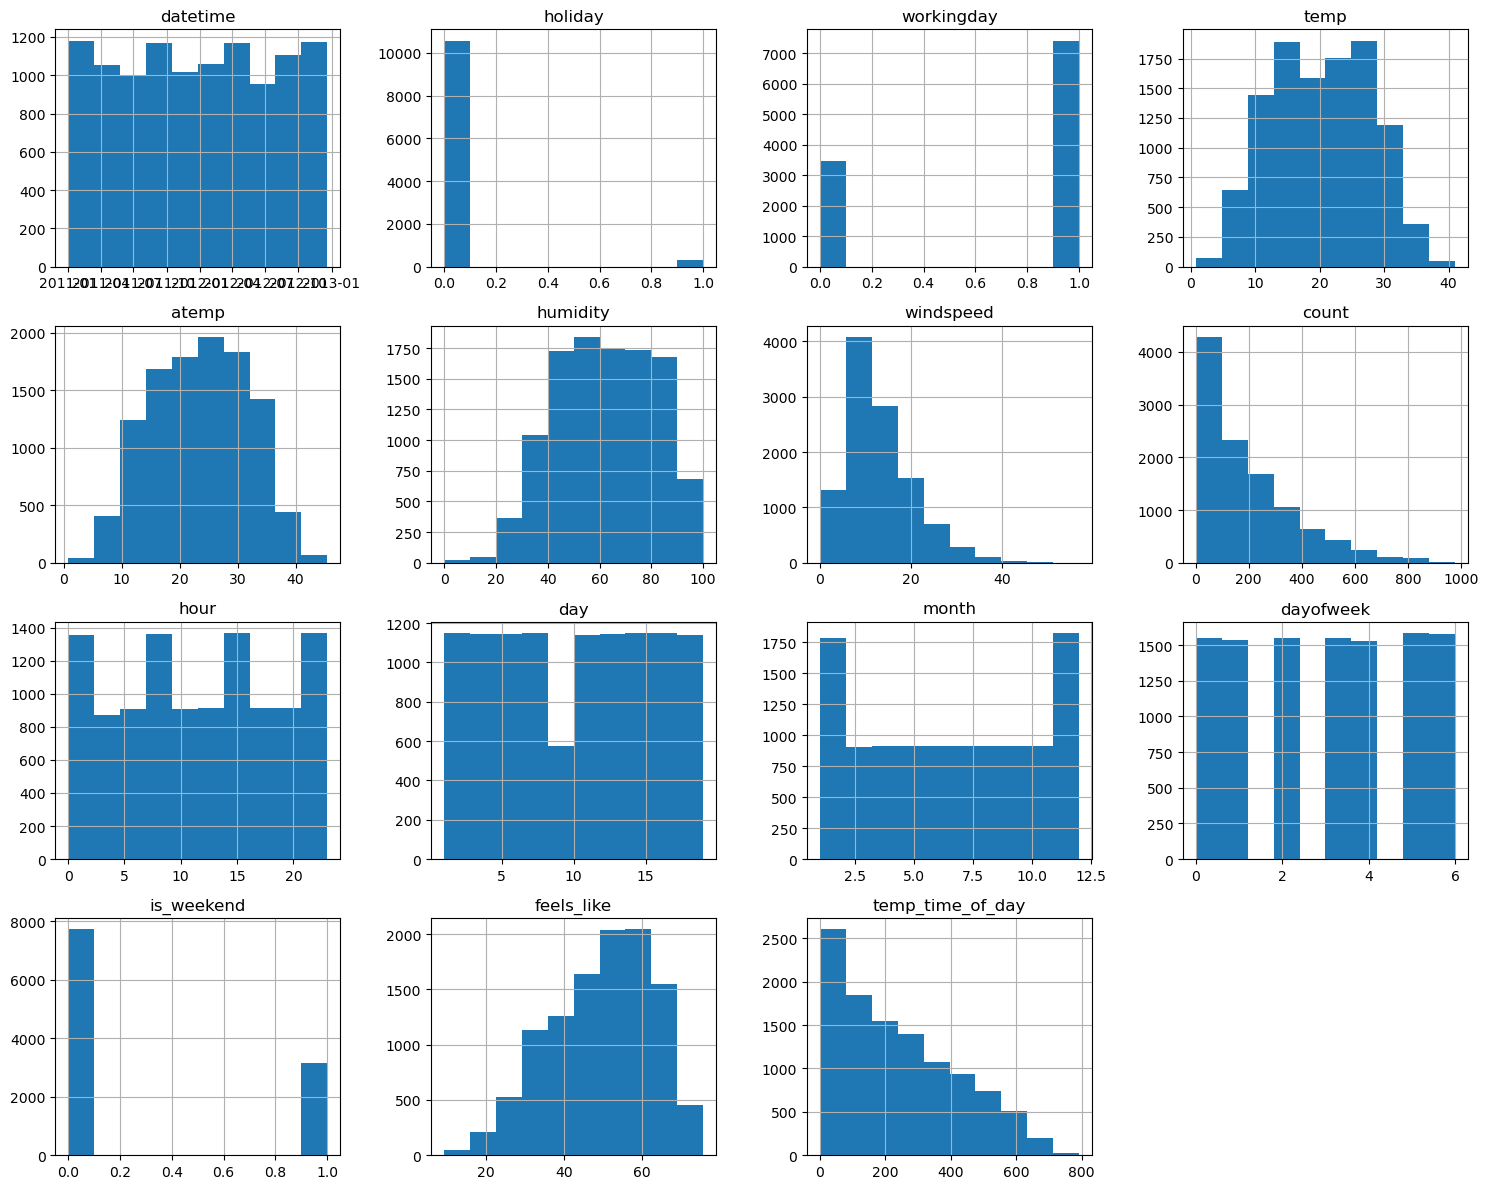

In [70]:
train.hist(figsize=(15, 12))
plt.tight_layout()
plt.show()

In [71]:
predictor_new_features_2 = TabularPredictor(label='count', eval_metric='root_mean_squared_error')
predictor_new_features_2.fit(train_data=train, presets='best_quality', time_limit=600)

No path specified. Models will be saved in: "AutogluonModels/ag-20240512_022407"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240512_022407/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 170 seconds

In [72]:
predictor_new_features_2.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.662413  root_mean_squared_error      28.616745  399.639991                0.000698           0.041085            3       True         12
1          LightGBM_BAG_L2  -31.075292  root_mean_squared_error      26.935424  309.284027                0.399543          34.604722            2       True         10
2        LightGBMXT_BAG_L2  -31.177126  root_mean_squared_error      27.449449  307.075440                0.913568          32.396135            2       True          9
3   RandomForestMSE_BAG_L2  -31.890124  root_mean_squared_error      27.302936  332.598049                0.767055          57.918744            2       True         11
4      WeightedEnsemble_L2  -32.603480  root_mean_squared_error      25.644790  261.898776   

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -34.21136186430484,
  'LightGBM_BAG_L1': -34.38896055152459,
  'RandomForestMSE_BAG_L1': -38.70614252762702,
  'CatBoost_BAG_L1': -37.56348053789313,
  'ExtraTreesMSE_BAG_L1': -38.41650261708729,
  'WeightedEnsemble_L2

In [73]:
predictions_new_features_2 = predictor_new_features_2.predict(test)
predictions_new_features_2.head()

0    14.593922
1     9.165100
2     8.421500
3     7.195772
4     6.578434
Name: count, dtype: float32

In [74]:
predictions_new_features_2.head()

0    14.593922
1     9.165100
2     8.421500
3     7.195772
4     6.578434
Name: count, dtype: float32

In [75]:
negative_count_predictions_new_features_2 = (predictions_new_features_2 < 0).sum()
print(f"Number of negative predictions with new features trial 2: {negative_count_predictions_new_features_2}")

Number of negative predictions with new features trial 2: 0


In [76]:
predictions_new_features_2[predictions_new_features_2 < 0] = 0

In [77]:
submission_new_features_2 = pd.read_csv("./Submission-3-HSSushmitha-new_features_2.csv")
submission_new_features_2.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [78]:
submission_new_features_2["count"] = predictions_new_features_2
submission_new_features_2.to_csv("Submission-3-HSSushmitha-new_features_2.csv", index=False)

In [79]:
!kaggle competitions submit -c bike-sharing-demand -f Submission-3-HSSushmitha-new_features_2.csv -m "new features trial 2"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 683kB/s]
Successfully submitted to Bike Sharing Demand

In [81]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                                     date                 description           status    publicScore  privateScore  
-------------------------------------------  -------------------  --------------------  --------  -----------  ------------  
Submission-3-HSSushmitha-new_features_2.csv  2024-05-12 02:36:17  new features trial 2  complete  0.61899      0.61899       
Submission-2-HSSushmitha-new_features.csv    2024-05-12 02:00:40  new features          complete  0.62779      0.62779       
Submission-1-HSSushmitha.csv                 2024-05-12 01:27:17  first submission      complete  1.80462      1.80462       


New Score trial 2 of 0.61899

#### TRIAL 3 - dropping 'temp_time_of_day' column

In [82]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month,dayofweek,is_weekend,part_of_day,feels_like,temp_time_of_day
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,0,1,1,5,1,Night,52.6175,0.00
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1,1,1,5,1,Night,51.3275,9.02
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2,1,1,5,1,Night,51.3275,18.04
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,3,1,1,5,1,Night,49.6175,29.52
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,4,1,1,5,1,Night,49.6175,39.36


In [85]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,month,dayofweek,is_weekend,part_of_day,feels_like,temp_time_of_day
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,0,20,1,3,0,Night,32.511825,0.00
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,20,1,3,0,Night,40.147500,10.66
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2,20,1,3,0,Night,40.147500,21.32
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,20,1,3,0,Night,37.019650,31.98
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,4,20,1,3,0,Night,37.019650,42.64


In [83]:
train = train.drop(['temp_time_of_day'], axis=1)

In [84]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month,dayofweek,is_weekend,part_of_day,feels_like
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,0,1,1,5,1,Night,52.6175
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1,1,1,5,1,Night,51.3275
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2,1,1,5,1,Night,51.3275
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,3,1,1,5,1,Night,49.6175
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,4,1,1,5,1,Night,49.6175


In [86]:
test = test.drop(['temp_time_of_day'], axis=1)
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,month,dayofweek,is_weekend,part_of_day,feels_like
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,0,20,1,3,0,Night,32.511825
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,20,1,3,0,Night,40.147500
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2,20,1,3,0,Night,40.147500
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,20,1,3,0,Night,37.019650
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,4,20,1,3,0,Night,37.019650


In [87]:
predictor_3 = TabularPredictor(label='count', eval_metric='root_mean_squared_error')
predictor_3.fit(train_data=train, presets='best_quality', time_limit=600)

No path specified. Models will be saved in: "AutogluonModels/ag-20240512_030619"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240512_030619/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 183 seconds

In [88]:
predictor_3.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.559300  root_mean_squared_error      20.194946  380.240985                0.000870           0.055267            3       True         12
1          LightGBM_BAG_L2  -30.850468  root_mean_squared_error      18.164281  296.940847                0.336565          31.697769            2       True         10
2        LightGBMXT_BAG_L2  -31.181489  root_mean_squared_error      19.179908  306.114921                1.352192          40.871843            2       True          9
3   RandomForestMSE_BAG_L2  -32.207989  root_mean_squared_error      18.505318  307.616106                0.677602          42.373028            2       True         11
4      WeightedEnsemble_L2  -32.783393  root_mean_squared_error      17.771600  265.237612   

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -34.8164941147007,
  'LightGBM_BAG_L1': -34.46404772981276,
  'RandomForestMSE_BAG_L1': -38.50881843691476,
  'CatBoost_BAG_L1': -36.91327704782099,
  'ExtraTreesMSE_BAG_L1': -38.009423115452876,
  'WeightedEnsemble_L2

In [89]:
predictions_3 = predictor_3.predict(test)
predictions_3.head()

0    14.745794
1     9.400495
2     8.690378
3     7.985929
4     7.286804
Name: count, dtype: float32

In [90]:
predictions_3.describe()

count    6493.000000
mean      162.109009
std       144.106033
min         2.624748
25%        49.212276
50%       125.471649
75%       231.025345
max       811.576538
Name: count, dtype: float64

In [91]:
negative_count_predictions_3 = (predictions_3 < 0).sum()
print(f"Number of negative predictions trial 3: {negative_count_predictions_3}")

Number of negative predictions trial 3: 0


In [92]:
predictions_3[predictions_3 < 0] = 0

In [93]:
submission_3 = pd.read_csv("./Submission-4-HSSushmitha.csv")
submission_3.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [94]:
submission_3["count"] = predictions_3
submission_3.to_csv("Submission-4-HSSushmitha.csv", index=False)

In [95]:
!kaggle competitions submit -c bike-sharing-demand -f Submission-4-HSSushmitha.csv -m "trial 3 - dropped temp_time_of_day feature"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 522kB/s]
Successfully submitted to Bike Sharing Demand

In [96]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                                     date                 description                                 status    publicScore  privateScore  
-------------------------------------------  -------------------  ------------------------------------------  --------  -----------  ------------  
Submission-4-HSSushmitha.csv                 2024-05-12 03:17:52  trial 3 - dropped temp_time_of_day feature  complete  0.63101      0.63101       
Submission-3-HSSushmitha-new_features_2.csv  2024-05-12 02:36:17  new features trial 2                        complete  0.61899      0.61899       
Submission-2-HSSushmitha-new_features.csv    2024-05-12 02:00:40  new features                                complete  0.62779      0.62779       
Submission-1-HSSushmitha.csv                 2024-05-12 01:27:17  first submission                            complete  1.80462      1.80462       


New Score trial 3 of 0.63101

#### TRIAL 4 - one hot encoding the categorical features

In [97]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month,dayofweek,is_weekend,part_of_day,feels_like
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,0,1,1,5,1,Night,52.6175
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1,1,1,5,1,Night,51.3275
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2,1,1,5,1,Night,51.3275
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,3,1,1,5,1,Night,49.6175
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,4,1,1,5,1,Night,49.6175


In [98]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,month,dayofweek,is_weekend,part_of_day,feels_like
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,0,20,1,3,0,Night,32.511825
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,20,1,3,0,Night,40.147500
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2,20,1,3,0,Night,40.147500
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,20,1,3,0,Night,37.019650
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,4,20,1,3,0,Night,37.019650


In [99]:
# Map categorical labels to numerical categories
part_of_day_mapping = {'Morning': 1, 'Afternoon': 2, 'Evening': 3, 'Night': 4}
train['part_of_day'] = train['part_of_day'].map(part_of_day_mapping)
test['part_of_day'] = test['part_of_day'].map(part_of_day_mapping)

train['part_of_day'] = train['part_of_day'].astype('category')
test['part_of_day'] = test['part_of_day'].astype('category')

In [100]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month,dayofweek,is_weekend,part_of_day,feels_like
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,0,1,1,5,1,4,52.6175
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1,1,1,5,1,4,51.3275
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2,1,1,5,1,4,51.3275
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,3,1,1,5,1,4,49.6175
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,4,1,1,5,1,4,49.6175


In [101]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,month,dayofweek,is_weekend,part_of_day,feels_like
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,0,20,1,3,0,4,32.511825
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,20,1,3,0,4,40.147500
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2,20,1,3,0,4,40.147500
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,20,1,3,0,4,37.019650
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,4,20,1,3,0,4,37.019650


In [102]:
print("Categorical columns in train dataset:")
print(train.select_dtypes(include=['category']).columns)

print()

print("Categorical columns in test dataset:")
print(test.select_dtypes(include=['category']).columns)

Categorical columns in train dataset:
Index(['season', 'weather', 'part_of_day'], dtype='object')

Categorical columns in test dataset:
Index(['season', 'weather', 'part_of_day'], dtype='object')


In [103]:
# List of categorical columns to be one-hot encoded
categorical_columns = ['season', 'weather', 'part_of_day']

# Apply one-hot encoding to the train dataset
train_encoded = pd.get_dummies(train, columns=categorical_columns)

# Apply one-hot encoding to the test dataset
test_encoded = pd.get_dummies(test, columns=categorical_columns)

print("New columns in train dataset after one-hot encoding:")
print(train_encoded.columns)

print("New columns in test dataset after one-hot encoding:")
print(test_encoded.columns)

New columns in train dataset after one-hot encoding:
Index(['datetime', 'holiday', 'workingday', 'temp', 'atemp', 'humidity',
       'windspeed', 'count', 'hour', 'day', 'month', 'dayofweek', 'is_weekend',
       'feels_like', 'season_1', 'season_2', 'season_3', 'season_4',
       'weather_1', 'weather_2', 'weather_3', 'weather_4', 'part_of_day_2',
       'part_of_day_3', 'part_of_day_1', 'part_of_day_4'],
      dtype='object')
New columns in test dataset after one-hot encoding:
Index(['datetime', 'holiday', 'workingday', 'temp', 'atemp', 'humidity',
       'windspeed', 'hour', 'day', 'month', 'dayofweek', 'is_weekend',
       'feels_like', 'season_1', 'season_2', 'season_3', 'season_4',
       'weather_1', 'weather_2', 'weather_3', 'weather_4', 'part_of_day_2',
       'part_of_day_3', 'part_of_day_1', 'part_of_day_4'],
      dtype='object')


In [104]:
train_encoded.head()

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,count,hour,day,...,season_3,season_4,weather_1,weather_2,weather_3,weather_4,part_of_day_2,part_of_day_3,part_of_day_1,part_of_day_4
0,2011-01-01 00:00:00,0,0,9.84,14.395,81,0.0,16,0,1,...,False,False,True,False,False,False,False,False,False,True
1,2011-01-01 01:00:00,0,0,9.02,13.635,80,0.0,40,1,1,...,False,False,True,False,False,False,False,False,False,True
2,2011-01-01 02:00:00,0,0,9.02,13.635,80,0.0,32,2,1,...,False,False,True,False,False,False,False,False,False,True
3,2011-01-01 03:00:00,0,0,9.84,14.395,75,0.0,13,3,1,...,False,False,True,False,False,False,False,False,False,True
4,2011-01-01 04:00:00,0,0,9.84,14.395,75,0.0,1,4,1,...,False,False,True,False,False,False,False,False,False,True


In [105]:
predictor_4 = TabularPredictor(label='count', eval_metric='root_mean_squared_error')
predictor_4.fit(train_data=train_encoded, presets='best_quality', time_limit=600)

No path specified. Models will be saved in: "AutogluonModels/ag-20240512_034620"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240512_034620/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 174 seconds

In [106]:
predictor_4.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.698888  root_mean_squared_error      14.480560  363.331519                0.001197           0.066404            3       True         12
1          CatBoost_BAG_L2  -30.983621  root_mean_squared_error      13.419816  302.228064                0.058526          39.464023            2       True         11
2          LightGBM_BAG_L2  -31.101012  root_mean_squared_error      13.601346  292.814112                0.240057          30.050072            2       True          9
3        LightGBMXT_BAG_L2  -31.543335  root_mean_squared_error      14.180781  293.751020                0.819491          30.986979            2       True          8
4   RandomForestMSE_BAG_L2  -32.360393  root_mean_squared_error      13.945609  286.160797   

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -34.8753511745175,
  'LightGBM_BAG_L1': -34.453388356812965,
  'RandomForestMSE_BAG_L1': -38.435692540035646,
  'CatBoost_BAG_L1': -34.1617708971648,
  'WeightedEnsemble_L2': -32.54251251293509,
  'LightGBMXT_BAG_L2':

In [108]:
predictions_4 = predictor_4.predict(test_encoded)
predictions_4.head()

0    14.538671
1    10.660473
2     9.820179
3     8.824557
4     8.038968
Name: count, dtype: float32

In [109]:
predictions_4.describe()

count    6493.000000
mean      157.649963
std       136.545410
min         2.303152
25%        51.642159
50%       122.551826
75%       224.549973
max       804.868347
Name: count, dtype: float64

In [110]:
negative_count_predictions_4 = (predictions_4 < 0).sum()
print(f"Number of negative predictions trial 4: {negative_count_predictions_4}")

Number of negative predictions trial 4: 0


In [111]:
predictions_4[predictions_4 < 0] = 0

In [112]:
submission_4 = pd.read_csv("./Submission-5-HSSushmitha.csv")
submission_4.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [113]:
submission_4["count"] = predictions_4
submission_4.to_csv("Submission-5-HSSushmitha.csv", index=False)

In [114]:
!kaggle competitions submit -c bike-sharing-demand -f Submission-5-HSSushmitha.csv -m "trial 4 - one hot encoding categorical features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 660kB/s]
Successfully submitted to Bike Sharing Demand

In [115]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                                     date                 description                                      status    publicScore  privateScore  
-------------------------------------------  -------------------  -----------------------------------------------  --------  -----------  ------------  
Submission-5-HSSushmitha.csv                 2024-05-12 03:58:05  trial 4 - one hot encoding categorical features  complete  0.66145      0.66145       
Submission-4-HSSushmitha.csv                 2024-05-12 03:17:52  trial 3 - dropped temp_time_of_day feature       complete  0.63101      0.63101       
Submission-3-HSSushmitha-new_features_2.csv  2024-05-12 02:36:17  new features trial 2                             complete  0.61899      0.61899       
Submission-2-HSSushmitha-new_features.csv    2024-05-12 02:00:40  new features                                     complete  0.62779      0.62779       


New Score trial 4 of 0.66145

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [122]:
hyperparameters = {
    'GBM': [{'num_boost_round': 100}, {'num_boost_round': 200}],
    'CAT': [{'iterations': 100}, {'iterations': 200}]
}

hyperparameter_tune_kwargs = {
    'num_trials': 5,
    'scheduler': 'local',
    'searcher': 'random'
}

In [123]:
predictor_new_hpo = TabularPredictor(label='count', eval_metric='root_mean_squared_error')
predictor_new_hpo.fit(train_data=train, hyperparameters=hyperparameters,
                      hyperparameter_tune_kwargs=hyperparameter_tune_kwargs, time_limit=600, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20240512_050213"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240512_050213/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 202 seconds

  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.91%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=1.42%)
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_BAG_L1/T1 ...
	-41.6479	 = Validation score   (-root_mean_squared_error)
	29.22s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L1/T2 ...
	-35.4737	 = Validation score   (-root_mean_squared_error)
	22.8s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: LightGBM_2_BAG_L1 ... Tuning model for up to 59.49s of the 344.38s of remaining time.


  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.88%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=1.42%)
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_2_BAG_L1/T1 ...
	-37.6306	 = Validation score   (-root_mean_squared_error)
	29.76s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_2_BAG_L1/T2 ...
	-34.5525	 = Validation score   (-root_mean_squared_error)
	34.36s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: CatBoost_BAG_L1 ... Tuning model for up to 59.49s of the 279.99s of remaining time.


  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=1.22%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.87%)
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L1/T1 ...
	-55.5065	 = Validation score   (-root_mean_squared_error)
	27.57s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: CatBoost_BAG_L1/T2 ...
	-49.7273	 = Validation score   (-root_mean_squared_error)
	25.78s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: CatBoost_2_BAG_L1 ... Tuning model for up to 59.49s of the 226.36s of remaining time.


  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=1.19%)
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_2_BAG_L1/T1 ...
	-46.2033	 = Validation score   (-root_mean_squared_error)
	39.07s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 187.03s of remaining time.
	Ensemble Weights: {'LightGBM_2_BAG_L1/T2': 0.923, 'LightGBM_2_BAG_L1/T1': 0.077}
	-34.5302	 = Validation score   (-root_mean_squared_error)
	0.04s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 4 L2 models ...
Hyperparameter tuning model: LightGBM_BAG_L2 ... Tuning model for up to 42.06s of the 186.91s of remaining time.


  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=1.19%)
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_BAG_L2/T1 ...
	-35.456	 = Validation score   (-root_mean_squared_error)
	29.83s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: LightGBM_2_BAG_L2 ... Tuning model for up to 42.06s of the 156.82s of remaining time.


  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=1.21%)
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_2_BAG_L2/T1 ...
	-35.4057	 = Validation score   (-root_mean_squared_error)
	33.54s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: CatBoost_BAG_L2 ... Tuning model for up to 42.06s of the 123.07s of remaining time.


  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=1.70%)
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L2/T1 ...
	-35.9197	 = Validation score   (-root_mean_squared_error)
	30.41s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: CatBoost_2_BAG_L2 ... Tuning model for up to 42.06s of the 92.4s of remaining time.


  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=1.67%)
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_2_BAG_L2/T1 ...
	-35.5583	 = Validation score   (-root_mean_squared_error)
	43.71s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: WeightedEnsemble_L3 ... Training model for up to 360.0s of the 48.41s of remaining time.
	Ensemble Weights: {'LightGBM_2_BAG_L1/T2': 0.864, 'LightGBM_2_BAG_L1/T1': 0.045, 'LightGBM_2_BAG_L2/T1': 0.045, 'CatBoost_2_BAG_L2/T1': 0.045}
	-34.531	 = Validation score   (-root_mean_squared_error)
	0.09s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 349.94s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20240512_050213")


In [124]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                   model  score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0    WeightedEnsemble_L2 -34.530194  root_mean_squared_error       0.001115   64.158552                0.000842           0.035968            2       True          8
1    WeightedEnsemble_L3 -34.531035  root_mean_squared_error       0.002403  285.904344                0.000979           0.087874            3       True         13
2   LightGBM_2_BAG_L1/T2 -34.552473  root_mean_squared_error       0.000133   34.359030                0.000133          34.359030            1       True          4
3   LightGBM_2_BAG_L2/T1 -35.405684  root_mean_squared_error       0.001285  242.110512                0.000294          33.544946            2       True         10
4     LightGBM_BAG_L2/T1 -35.456018  root_mean_squared_error       0.001132  238.391326                0.000

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_2_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_2_BAG_L1/T2': 'StackerEnsembleModel_LGB',
  'CatBoost_BAG_L1/T1': 'StackerEnsembleModel_CatBoost',
  'CatBoost_BAG_L1/T2': 'StackerEnsembleModel_CatBoost',
  'CatBoost_2_BAG_L1/T1': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBM_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_2_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'CatBoost_BAG_L2/T1': 'StackerEnsembleModel_CatBoost',
  'CatBoost_2_BAG_L2/T1': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBM_BAG_L1/T1': -41.64785304916896,
  'LightGBM_BAG_L1/T2': -35.47367986394226,
  'LightGBM_2_BAG_L1/T1': -37.630627565896404,
  'LightGBM_2_BAG_L1/T2': -34.55247290301754,
  'CatBoost_BAG_L1/T1': -55.50654435516091,
  'CatBoost_BAG_L1/T2': -49.727

In [125]:
predictions_hpo = predictor_new_hpo.predict(test)
predictions_hpo.head()

0    12.237848
1    -0.145836
2    -3.543509
3     0.853264
4     0.853264
Name: count, dtype: float32

In [126]:
predictions_hpo.describe()

count    6493.000000
mean      192.791153
std       174.532593
min        -6.431588
25%        46.799824
50%       150.893250
75%       285.277802
max       902.617432
Name: count, dtype: float64

In [127]:
negative_count_predictions_hpo = (predictions_hpo < 0).sum()
print(f"Number of negative predictions hpo: {negative_count_predictions_hpo}")

Number of negative predictions hpo: 47


In [128]:
predictions_hpo[predictions_hpo < 0] = 0

In [129]:
submission_new_hpo = pd.read_csv("./Submission-6-HSSushmitha-new-hpo.csv")
submission_new_hpo.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [130]:
# Same submitting predictions
submission_new_hpo["count"] = predictions_hpo
submission_new_hpo.to_csv("Submission-6-HSSushmitha-new-hpo.csv", index=False)

In [132]:
!kaggle competitions submit -c bike-sharing-demand -f Submission-6-HSSushmitha-new-hpo.csv -m "with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 588kB/s]
Successfully submitted to Bike Sharing Demand

In [133]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                                     date                 description                                      status    publicScore  privateScore  
-------------------------------------------  -------------------  -----------------------------------------------  --------  -----------  ------------  
Submission-6-HSSushmitha-new-hpo.csv         2024-05-12 05:21:02  with hyperparameters                             complete  0.49549      0.49549       
Submission-5-HSSushmitha.csv                 2024-05-12 03:58:05  trial 4 - one hot encoding categorical features  complete  0.66145      0.66145       
Submission-4-HSSushmitha.csv                 2024-05-12 03:17:52  trial 3 - dropped temp_time_of_day feature       complete  0.63101      0.63101       
Submission-3-HSSushmitha-new_features_2.csv  2024-05-12 02:36:17  new features trial 2                             complete  0.61899      0.61899       


#### New Score of 0.49549

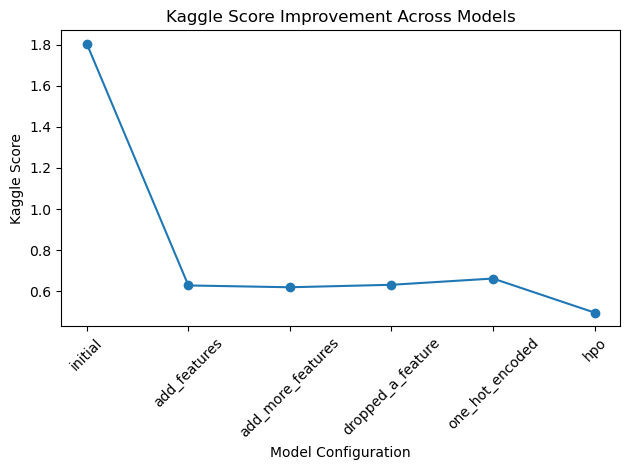

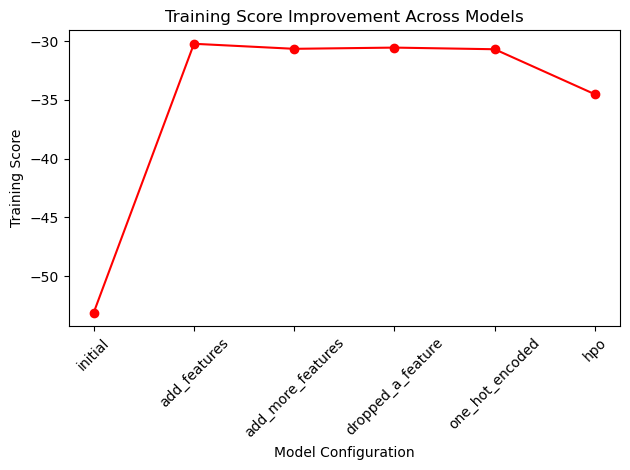

In [141]:
import pandas as pd
import matplotlib.pyplot as plt

scores = [1.80462, 0.62779, 0.61899, 0.63101, 0.66145, 0.49549]
models = ["initial", "add_features", "add_more_features", "dropped_a_feature", "one_hot_encoded", "hpo"]

# Plot for Kaggle scores
fig, ax = plt.subplots()
ax.plot(models, scores, marker='o')
ax.set_xlabel('Model Configuration')
ax.set_ylabel('Kaggle Score')
ax.set_title('Kaggle Score Improvement Across Models')
ax.set_xticks(range(len(models)))
ax.set_xticklabels(models, rotation=45)
fig.tight_layout()
fig.savefig('model_test_score.png')

train_scores = [-53.100012, -30.233831, -30.662413, -30.559300, -30.698888, -34.530194]

# Plot for training scores
fig_train, ax_train = plt.subplots()
ax_train.plot(models, train_scores, marker='o', color='r')
ax_train.set_xlabel('Model Configuration')
ax_train.set_ylabel('Training Score')
ax_train.set_title('Training Score Improvement Across Models')
ax_train.set_xticks(range(len(models)))
ax_train.set_xticklabels(models, rotation=45) 
fig_train.tight_layout()
fig_train.savefig('model_train_score.png')

### Hyperparameter table

In [142]:
df = pd.DataFrame({
    "model": ["initial", "add_features", "add_more_features", "dropped_a_feature", "one_hot_encoded", "hpo"],
    "hpo1": ["default", "default", "default", "default", "default", "num_boost_round: 100 to 200"],
    "hpo2": ["default", "default", "default", "default", "default", "iterations: 100 to 200"],
    "hpo3": ["default", "default", "default", "default", "default", "num_trials: 5, scheduler: local, searcher: random"],
    "score": [1.80462, 0.62779, 0.61899, 0.63101, 0.66145, 0.49549]
})

df

,model,hpo1,hpo2,hpo3,score
0,initial,default,default,default,1.80462
1,add_features,default,default,default,0.62779
2,add_more_features,default,default,default,0.61899
3,dropped_a_feature,default,default,default,0.63101
4,one_hot_encoded,default,default,default,0.66145
5,hpo,num_boost_round: 100 to 200,iterations: 100 to 200,"num_trials: 5, scheduler: local, searcher: random",0.49549
